<a href="https://colab.research.google.com/github/noafrimerman/BCI/blob/main/bci1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import h5py
import numpy as np
from scipy.signal import resample
import pickle
import argparse
import matplotlib.pyplot as plt


"""
Preprocessing script for EEG .mat files.

This script processes all .mat files in a given folder by:
- Downsampling EEG data from 1000 Hz to 250 Hz.
- Applying Common Average Referencing (CAR).
- Creating 1-second sliding windows (250 time points per window, step of 40 ms).
- Extracting cursor and target positions and generating labels.
- Supporting two labeling types: 'regression' (normalized direction vectors) and 'classification' (CHANGE?)
- Saving preprocessed data as individual .pkl files in a 'preprocessed' subfolder.
- Labeling (for classification): 0 = Neutral, 1 = Left, 2 = Right.

Example usage:
python preprocess.py --data_folder path/to/mat_files --label_type regression
"""


def process_file(filepath, label_type):
    # Load EEG data
    with h5py.File(filepath, 'r') as mat:
        eeg_data = mat['eeg']['data'][:].T  # shape: (n_channels, n_samples)
        original_fs = 1000
        target_fs = 250

        # Downsample EEG from 1000Hz to 250Hz
        n_timepoints_downsampled = int(eeg_data.shape[1] * target_fs / original_fs)
        eeg_downsampled = resample(eeg_data, n_timepoints_downsampled, axis=1)

        # Apply Common Average Referencing (CAR)
        eeg_car = eeg_downsampled - np.mean(eeg_downsampled, axis=0, keepdims=True)

        # Create sliding windows (1 second window, step 40ms)
        samples_per_window = int(target_fs)  # 250 samples
        step_size = int(target_fs * 0.04)    # 40 ms step
        start_indices = range(0, eeg_car.shape[1] - samples_per_window + 1, step_size)

        eeg_windows = np.stack([
            eeg_car[:, start:start + samples_per_window]
            for start in start_indices
        ])

        # Extract cursor and target positions
        cursor_x = mat['eeg']['cursorpos']['x'][:]
        cursor_y = mat['eeg']['cursorpos']['y'][:]
        target_x = mat['eeg']['targetpos']['x'][:]
        target_y = mat['eeg']['targetpos']['y'][:]

        cursor = np.stack([cursor_x, cursor_y])
        target = np.stack([target_x, target_y])

        # Downsample cursor and target positions
        cursor_resampled = resample(cursor, n_timepoints_downsampled, axis=1)
        target_resampled = resample(target, n_timepoints_downsampled, axis=1)

        # For segmentation
        postimes = mat['eeg']['postimes'][:]
        postimes_resampled = np.linspace(postimes[0], postimes[-1], eeg_car.shape[1])  # align with downsampled EEG
        target_x_resampled = resample(target_x, n_timepoints_downsampled)

        # Calculate labels per window
        labels = []
        for start in start_indices:
            if label_type == 'regression':
                # Calculate the average position of cursor and target in the window
                avg_cursor = np.mean(cursor_resampled[:, start:start + samples_per_window], axis=1).reshape(-1)
                avg_target = np.mean(target_resampled[:, start:start + samples_per_window], axis=1).reshape(-1)

                # Compute the direction vector from cursor to target
                vec = avg_target - avg_cursor
                norm = np.linalg.norm(vec)

                # Normalize vector to unit length (regression case)
                label = vec / norm if norm != 0 else np.zeros_like(vec)

            elif label_type == 'classification':
                # Classification: Calculate delta between start and end of the window
                cursor_start = cursor_resampled[:, start]
                cursor_end = cursor_resampled[:, start + samples_per_window - 1]

                delta_x = cursor_end[0] - cursor_start[0]
                delta_y = cursor_end[1] - cursor_start[1]

                # First check the Y-axis movement (more significant)
                if abs(delta_y) > abs(delta_x):
                    label = 0  # Neutral (0)
                elif delta_x > 0:
                    label = 2  # Right (2)
                elif delta_x < 0:
                    label = 1  # Left (1)
                else:
                    label = 0  # Neutral (0) - no significant movement
            else:
                raise ValueError(f"Unknown label type: {label_type}")

            labels.append(label)

        labels = np.array(labels)

    return eeg_windows, labels


def main(data_folder, label_type):

    # Create a subfolder for preprocessed files, named "preprocessed"
    # preprocessed_folder = os.path.join(data_folder, 'preprocessed')
    # os.makedirs(preprocessed_folder, exist_ok=True)  # Create if it doesn't exist

    ### preprocessed_folder = 'pklFileLocation' --- original code
    preprocessed_folder = os.path.join(data_folder, 'preprocessed')

    # Process all .mat files in the given folder
    for filename in os.listdir(data_folder):
        # filepath = os.path.join(data_folder, filename)
        if filename.endswith('.mat'):
            filepath = os.path.join(data_folder, filename)

            # Extract subject, session, model type, and trial from filename
            # Example filename: S26_Se01_AR_R01.mat
            base_name = os.path.splitext(filename)[0]  # Remove .mat extension
            parts = base_name.split('_')
            subject = parts[0]
            session = parts[1]
            model = parts[2]
            trial = parts[3]

            # Construct output filename
            output_filename = f"{subject}_{session}_{model}_{trial}_preprocessed_{label_type}.pkl"
            output_path = os.path.join(preprocessed_folder, output_filename)

            # if pickle file already exists; continue
            if os.path.exists(output_path):
                continue

            eeg_windows, labels = process_file(filepath, label_type)

            if (label_type == 'segmentation'):
                lrp_avg, all_lrps = compute_lrp_smuller_method(eeg_windows, labels, labels)
                plot_lrp(lrp_avg, fs=250)

            # Save preprocessed data
            output = {
                'eeg_windows': eeg_windows,  # shape: (n_windows, n_channels, 250)
                'labels': labels             # shape: (n_windows, 2) or another shape
            }

            with open(output_path, 'wb') as f:
                pickle.dump(output, f)

            # print(f"Saved {eeg_windows.shape[0]} windows and labels to '{output_path}'")


def extract_channel_labels(h5_file):
    label_refs = h5_file['eeg']['channellabels'][:]  # shape: (n_channels, 1) or (n_channels,)

    labels = []
    for ref in label_refs:
        # Handle both 1D and 2D references
        ref_obj = ref[0] if isinstance(ref, (np.ndarray, list)) else ref
        label_data = h5_file[ref_obj][:]

        # Case 1: label is array of ASCII codes (e.g., [67, 51] for 'C3')
        if np.issubdtype(label_data.dtype, np.integer):
            label = ''.join(chr(c) for c in label_data.flatten())
        # Case 2: label is already a byte string (e.g., b'C3')
        elif label_data.dtype.kind in {'S', 'O'}:
            label = label_data[()].decode('utf-8') if isinstance(label_data[()], bytes) else str(label_data[()])
        else:
            raise ValueError(f"Unexpected label format: {label_data}")

        labels.append(label.strip())

    return labels


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:

## THIS CODE CALLS THE FUNCTION THAT IMPROTS THE MAT FOLDER TO PKL FOLDER
data_folder = "/content/drive/MyDrive/BCI/mat_files/SO1"   # mat. files folder
label_type = "regression"

main(data_folder, label_type)


In [10]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 78.0 MB/s eta 0:00:00


In [25]:
##  THIS CODE TRANSFORM THE LABELS TO "RIGHT" / "LEFT"
def label_to_text(label):
    # convert numeric or vector labels to text
    if isinstance(label, (np.ndarray, list)):
        # if it's a 2D vector [dx, dy]
        if label[0] > 0:
            return "Right"
        elif label[0] < 0:
            return "Left"
        else:
            return "Neutral"
    elif isinstance(label, (int, float)):
        # if labels are numeric 0/1/2
        if label == 2:
            return "Right"
        elif label == 1:
            return "Left"
        else:
            return "Neutral"
    else:
        return str(label)



In [29]:
import os
import pickle
import numpy as np
import mne

# path to folder with pkl files
pkl_folder = "/content/drive/MyDrive/BCI/mat_files/SO1/preprocessed"

data_dict = {}

for filename in os.listdir(pkl_folder):
    if not filename.endswith(".pkl"):
        continue

    # parse subject/session from filename
    base = filename.split("_")
    subject = base[0]   # e.g. 'S01'
    session = base[1]   # e.g. 'Se01'
    session_num = int(session.replace("Se", ""))

    filepath = os.path.join(pkl_folder, filename)
    with open(filepath, "rb") as f:
        data = pickle.load(f)

    eeg_windows = data["eeg_windows"]   # shape: (n_windows, n_channels, 250)
    labels = data["labels"]             # shape: (n_windows, 2) or numeric labels

    label_dict = {i: label_to_text(labels[i]) for i in range(len(labels))} # using label to text

    if subject not in data_dict:
        data_dict[subject] = {}
    data_dict[subject][session_num] = (raw, label_dict)

    # combine all EEG windows along time
    eeg_concat = np.concatenate(eeg_windows, axis=1)  # shape (n_channels, total_time)

    # sampling frequency (from preprocessing)
    sfreq = 250
    n_channels = eeg_concat.shape[0]
    ch_names = [f"Ch{i+1}" for i in range(n_channels)]

    # build MNE Raw object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
    raw = mne.io.RawArray(eeg_concat, info)


    # insert into main dict
    if subject not in data_dict:
        data_dict[subject] = {}

    data_dict[subject][session_num] = (raw, label_dict)

# check the structure
print(data_dict.keys())                     # subjects
print(data_dict["S01"].keys())              # sessions
print(type(data_dict["S01"][1][0]))         # should be mne.io.RawArray
print(len(data_dict["S01"][1][1]))          # number of labels
print(list(data_dict["S01"][1][1].items())[:5])  # first 5 labels


Creating RawArray with float64 data, n_channels=62, n_times=1977000
    Range : 0 ... 1976999 =      0.000 ...  7907.996 secs
Ready.
Creating RawArray with float64 data, n_channels=62, n_times=1976750
    Range : 0 ... 1976749 =      0.000 ...  7906.996 secs
Ready.
Creating RawArray with float64 data, n_channels=62, n_times=1977250
    Range : 0 ... 1977249 =      0.000 ...  7908.996 secs
Ready.
dict_keys(['S01'])
dict_keys([1])
<class 'mne.io.array._array.RawArray'>
7909
[(0, 'Right'), (1, 'Right'), (2, 'Right'), (3, 'Right'), (4, 'Right')]


In [33]:
for subject, sessions in data_dict.items():
    print(f"Subject: {subject}")
    for session_num, (raw, labels) in sessions.items():
        print(f"  Session: {session_num}")
        print(f"    EEG type: {type(raw).__name__}")  # should be RawArray
        print(f"    EEG shape: {len(raw.ch_names)} channels × {raw.n_times} samples")
        print(f"    Sampling rate: {raw.info['sfreq']} Hz")
        print(f"    Labels type: {type(labels).__name__}")
        print(f"    Number of labels: {len(labels)}")
        # Print first 3 labels for reference
        sample_labels = list(labels.items())[:50]
        print(f"    Example labels: {sample_labels}")
    print()


Subject: S01
  Session: 1
    EEG type: RawArray
    EEG shape: 62 channels × 1977250 samples
    Sampling rate: 250.0 Hz
    Labels type: dict
    Number of labels: 7909
    Example labels: [(0, 'Right'), (1, 'Right'), (2, 'Right'), (3, 'Right'), (4, 'Right'), (5, 'Right'), (6, 'Right'), (7, 'Right'), (8, 'Right'), (9, 'Right'), (10, 'Right'), (11, 'Right'), (12, 'Right'), (13, 'Right'), (14, 'Right'), (15, 'Right'), (16, 'Right'), (17, 'Right'), (18, 'Right'), (19, 'Right'), (20, 'Right'), (21, 'Right'), (22, 'Right'), (23, 'Right'), (24, 'Right'), (25, 'Right'), (26, 'Right'), (27, 'Right'), (28, 'Right'), (29, 'Right'), (30, 'Right'), (31, 'Right'), (32, 'Right'), (33, 'Right'), (34, 'Right'), (35, 'Right'), (36, 'Right'), (37, 'Right'), (38, 'Right'), (39, 'Right'), (40, 'Right'), (41, 'Right'), (42, 'Right'), (43, 'Right'), (44, 'Right'), (45, 'Right'), (46, 'Right'), (47, 'Left'), (48, 'Left'), (49, 'Left')]



In [37]:
sample_labels = list(data_dict["S01"][1][1].values())[0:550]
# סופרים כמה מכל סוג
right_count = sample_labels.count("Right")
left_count = sample_labels.count("Left")
neutral_count = sample_labels.count("Neutral")

# מדפיסים את התוצאות
print(f"Right: {right_count}")
print(f"Left: {left_count}")
print(f"Neutral: {neutral_count}")
print(f"Total: {len(sample_labels)}")


Right: 246
Left: 304
Neutral: 0
Total: 550


Found 3 MAT files.
Processing S01_Se01_AR_R01.mat ...
  → 558 events detected
Processing S01_Se01_AR_R02.mat ...
  → 554 events detected
Processing S01_Se01_AR_R03.mat ...
  → 573 events detected
Total events across all files: 1685
Average duration: 0.25626112759643915


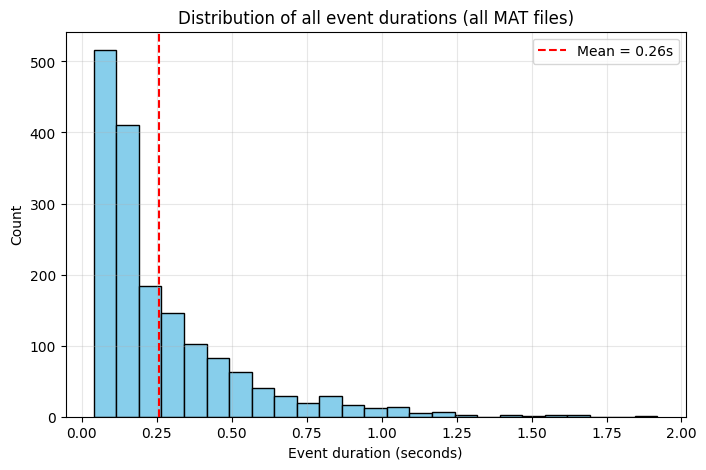

In [7]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# --- smooth function ---
def moving_average(x, k=5):
    k = max(1, int(k))
    return np.convolve(x, np.ones(k)/k, mode='same')

# --- detect events from a MAT file ---
def detect_events_from_mat(mat_path, fs_positions=25, eps_x=0.005, eps_y=0.02):
    """
    Detect Left/Right/BothHands events based on target motion.
    eps_x and eps_y set lower thresholds to detect more events.
    """
    with h5py.File(mat_path, "r") as f:
        eeg = f["eeg"]

        target_x = np.array(eeg["targetpos"]["x"]).flatten()
        target_y = np.array(eeg["targetpos"]["y"]).flatten()

    dx = np.diff(target_x)
    dy = np.diff(target_y)

    # smoother but not too much
    dx_s = moving_average(dx, 3)
    dy_s = moving_average(dy, 3)

    # direction labels
    state = np.full(dx_s.shape, "Neutral", dtype=object)
    state[dx_s > eps_x] = "Right"
    state[dx_s < -eps_x] = "Left"
    state[np.abs(dy_s) > eps_y] = "BothHands"

    events = []
    durations = []

    last_state = state[0]
    last_idx = 0

    for i in range(1, len(state)):
        if state[i] != last_state:
            dur = (i - last_idx) / fs_positions
            if last_state != "Neutral":
                events.append({
                    "start_idx": last_idx,
                    "end_idx": i,
                    "duration_s": dur,
                    "label": last_state
                })
                durations.append(dur)

            last_state = state[i]
            last_idx = i

    return events, durations

# --- PROCESS ALL FILES IN A FOLDER ---
def process_folder(folder_path):
    all_durations = []

    files = [f for f in os.listdir(folder_path) if f.endswith(".mat")]
    print(f"Found {len(files)} MAT files.")

    for filename in files:
        mat_path = os.path.join(folder_path, filename)
        print(f"Processing {filename} ...")

        events, durations = detect_events_from_mat(mat_path)

        print(f"  → {len(events)} events detected")

        all_durations.extend(durations)

    return all_durations


# --- RUNNING ---
folder = "/content/drive/MyDrive/BCI/mat_files/SO1"   #
all_durations = process_folder(folder)

# --- SUMMARY ---
print("Total events across all files:", len(all_durations))
print("Average duration:", np.mean(all_durations) if all_durations else 0)

# --- PLOT ---
plt.figure(figsize=(8,5))
plt.hist(all_durations, bins=25, color='skyblue', edgecolor='black')
plt.axvline(np.mean(all_durations), color='red', linestyle='--', label=f"Mean = {np.mean(all_durations):.2f}s")
plt.xlabel("Event duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of all event durations (all MAT files)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [12]:
## trying to write a code to find the right eps_x and eps_y, to define the labels.

import os
import h5py
import numpy as np

def compute_epsilons_for_folder(folder_path, percentile=95):
    all_dx = []
    all_dy = []

    files = [f for f in os.listdir(folder_path) if f.endswith(".mat")]
    print(f"Found {len(files)} MAT files.")

    for filename in files:
        mat_path = os.path.join(folder_path, filename)
        print(f"Reading {filename} ...")

        with h5py.File(mat_path, "r") as f:
            eeg = f["eeg"]
            x = np.array(eeg["targetpos"]["x"]).flatten()
            y = np.array(eeg["targetpos"]["y"]).flatten()

        dx = np.abs(np.diff(x))
        dy = np.abs(np.diff(y))

        all_dx.extend(dx)
        all_dy.extend(dy)

    # convert to numpy arrays
    all_dx = np.array(all_dx)
    all_dy = np.array(all_dy)

    # compute percentile thresholds
    eps_x = np.percentile(all_dx, percentile)
    eps_y = np.percentile(all_dy, percentile)

    return eps_x, eps_y

folder = "/content/drive/MyDrive/BCI/mat_files/SO1"
eps_x, eps_y = compute_epsilons_for_folder(folder, percentile=95)

print("Recommended eps_x =", eps_x)
print("Recommended eps_y =", eps_y)

Found 6 MAT files.
Reading S01_Se01_AR_R01.mat ...
Reading S01_Se01_AR_R02.mat ...
Reading S01_Se01_AR_R03.mat ...
Reading S01_Se01_AR_R06.mat ...
Reading S01_Se01_AR_R04.mat ...
Reading S01_Se01_AR_R05.mat ...
Recommended eps_x = 0.0138095238095238
Recommended eps_y = 0.013333333333333336


data_dict for my data.
last edited: 08/12/25